In [17]:
import pandas as pd
import re
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from nltk.probability import FreqDist
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_csv('/content/drive/MyDrive/data_cleaned_1.csv')

In [4]:
data.isnull().sum().max()

34

In [5]:
data = data.dropna()

In [6]:
data.isnull().sum().max()

0

In [7]:
data['text'] = data['text'].astype(str)

In [8]:
data['dialect_cat'] = data['dialect'].factorize()[0]

In [9]:
category_id_df = data[['dialect', 'dialect_cat']].drop_duplicates()
id_to_category = dict(category_id_df[['dialect_cat', 'dialect']].values)
id_to_category

{0: 'IQ',
 1: 'LY',
 2: 'QA',
 3: 'PL',
 4: 'SY',
 5: 'TN',
 6: 'JO',
 7: 'MA',
 8: 'SA',
 9: 'YE',
 10: 'DZ',
 11: 'EG',
 12: 'LB',
 13: 'KW',
 14: 'OM',
 15: 'SD',
 16: 'AE',
 17: 'BH'}

In [10]:
data

,id,text,dialect,dialect_cat
0,1175358310087892992,بالنهاية ينتفض يغير,IQ,0
1,1175416117793349632,يعني محسوب البشر حيونه ووحشيه وتطلبون الغرب يح...,IQ,0
2,1175450108898565888,مبين كلامه خليجي,IQ,0
3,1175471073770573824,يسلملي مرورك وروحك الحلوه,IQ,0
4,1175496913145217024,وين الغيبه اخ محمد,IQ,0
...,...,...,...,...
457996,1088437262499659776,بالعافيه فقلي الاكل,BH,17
457997,1088665169616687232,مدح يبي,BH,17
457998,1090527423844806784,ايييي احبها واحب طاوله للكرك ويفضل ان تكون بلك...,BH,17
457999,1090947679977439232,جيبي مطرقه شوفي اهدم واهدم ابوه,BH,17


# Data Visualization

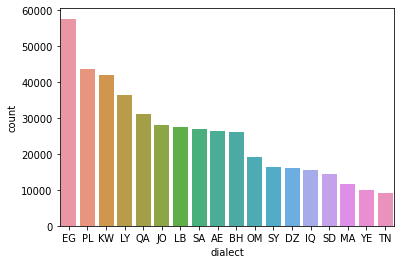

In [11]:
sns.countplot(x = 'dialect',
              data = data,
              order = data['dialect'].value_counts().index)

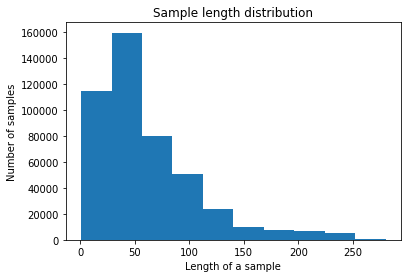

In [12]:
def plot_sample_length_distribution(sample_texts):
    plt.hist([len(s) for s in sample_texts])
    plt.xlabel('Length of a sample')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution')
    plt.show()


plot_sample_length_distribution(data['text'].values.astype('U'))

## Sampling the data to try on multiple models

In [13]:
sample = data.sample(frac=0.1)

In [14]:
sample

,id,text,dialect,dialect_cat
122558,1155530389160640512,الله الله روعه فخامه وصح لسانك فعلا ماكل ركب ا...,PL,3
123545,494423088613040128,احنا يومين صارلها وﻻ دقيقة اجت ربنا يفرجها ان ...,PL,3
40944,866443394163322880,قالو اليهود يقولو كنك ليبي ياراجل,LY,1
64391,455314803901210624,ماني فاتح باب قلبي للاحرآج ماحب آكون انسان ماه...,QA,2
311949,1159464756345999360,انسى عالحكي كنا اشترينا نحنا نجوم العالم,LB,12
...,...,...,...,...
262300,789337465828024320,بيتخزن التجار الجاشعين روح وشوف,EG,11
293991,825438708006531072,مؤتمر الشباب دا كمية تعريص انما ايه عنب,EG,11
237021,655088033771950080,ههههههه يا اختي سمعتها مت بالضحك,DZ,10
4031,966790653526073216,ادري هاي وين لكيتوها يمكن جيل 2000 جاي ايدور ب...,IQ,0


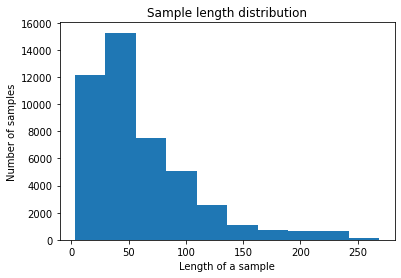

In [15]:
plot_sample_length_distribution(sample['text'].values.astype('U'))

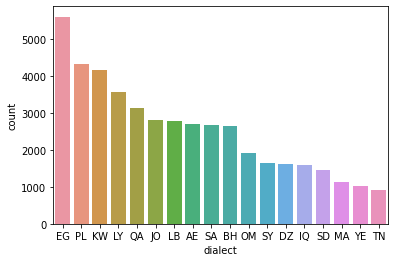

In [16]:
sns.countplot(x = 'dialect',
              data = sample,
              order = sample['dialect'].value_counts().index)

### Using TFIDF vectorizer to transform the data

In [19]:
#Using TFidf vectorizer on a sample data so we can choose whcih model to deploy with the whole data.
tf_1=TfidfVectorizer()
text_tf1= tf_1.fit_transform(sample['text'])
y_sample = sample['dialect_cat'] 

### Models Training on the sample dataset

In [23]:
#Creating a list of models to compare the cross-validation mean accuracy at the end of the training.
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, text_tf1, y_sample, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [28]:
cv_df

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.123144
1,RandomForestClassifier,1,0.123362
2,RandomForestClassifier,2,0.122830
3,RandomForestClassifier,3,0.122939
4,RandomForestClassifier,4,0.124904
5,LinearSVC,0,0.415939
6,LinearSVC,1,0.406004
7,LinearSVC,2,0.417622
8,LinearSVC,3,0.413910
9,LinearSVC,4,0.417294


## Models Mean Accuracy

In [30]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
mean_accuracy

model_name
LinearSVC                 0.414154
LogisticRegression        0.389742
MultinomialNB             0.289495
RandomForestClassifier    0.123436
Name: accuracy, dtype: float64


# Model Preprocessing & Training "Full Data"
---


### Using TFIDF

In [ ]:
tf=TfidfVectorizer()
text_tf= tf.fit_transform(data['text'])

In [ ]:
import pickle
pickle.dump(tf, open("tfidf1.pkl", "wb"))

### Splitting the dataset

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(text_tf,data['dialect_cat'], test_size=0.25,random_state=1,stratify = data['dialect_cat'])

In [ ]:
print(X_train.shape)
print(y_train.shape)

### Model Training

In [ ]:
model = LinearSVC()
scores = cross_val_score(model, X_train, y_train,cv=10)
scores

array([0.52908297, 0.52561863, 0.52687045, 0.52098981, 0.52576419,
       0.52439592, 0.52902475, 0.52669578, 0.53018923, 0.53144105])

In [ ]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

### Model Evaluation

In [ ]:
print(metrics.classification_report(y_test, y_pred, target_names= data['dialect'].unique()))

              precision    recall  f1-score   support

          IQ       0.60      0.53      0.56      3874
          LY       0.64      0.68      0.66      9125
          QA       0.46      0.48      0.47      7767
          PL       0.47      0.53      0.50     10936
          SY       0.46      0.33      0.38      4061
          TN       0.68      0.48      0.56      2311
          JO       0.40      0.34      0.37      6980
          MA       0.74      0.59      0.65      2885
          SA       0.41      0.42      0.41      6708
          YE       0.37      0.21      0.27      2482
          DZ       0.61      0.53      0.57      4046
          EG       0.70      0.85      0.77     14409
          LB       0.62      0.66      0.64      6904
          KW       0.49      0.58      0.53     10527
          OM       0.39      0.33      0.36      4779
          SD       0.69      0.57      0.62      3609
          AE       0.42      0.41      0.42      6574
          BH       0.39    

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.5342049414415595

In [ ]:
import pickle
filename = 'LinearSVC_model.sav'
pickle.dump(model, open(filename, 'wb'))